**Deploying the FoodVision Mini model to the internet as a usable app.**

![What is ML deployment ?](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-what-is-model-deployment-someone-or-something-else.png)

*Machine learning model deployment involves making your model available to someone or something else. For example, someone might use your model as part of a food recognition app (such as FoodVision Mini or Nutrify). And something else might be another model or program using your model such as a banking system using a machine learning model to detect if a transaction is fraud or not.*

**Deploying a model is as important as training one.**

Because of this philosophical question:

![Why deploy an ML model ?](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-does-it-exist.jpeg)

Model deployment also helps figure out errors in the model thar are not obvious during training/testing. This is why it is important.

![Complete ML lifecycle with deployment](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-pytorch-workflow-with-deployment.png)

*Deployment is a good next step after getting a good model. Monitoring involves seeing how the model goes on the most important data split: data from the real world.*

### Different types of ML model deployment

Good to ask the question:
**What is the most ideal scenario for the ML model to be used ?**

And then work backwards from there.

![Thoughts of ML deployment](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-deployment-questions-to-ask.png)

**So, for FoodVision Mini, the deployment will be done On-device (edge). Also, its inference pipeline will happen online (immediately) and its training pipeline will happen offline (batch).**

![Ways to deploy an ML model](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-tools-and-places-to-deploy-ml-models.png)

The goal is to deploy the FoodVision Mini model via a demo Gradio app with the following metrics:

    1. Performance: 95%+ accuracy.
    2. Speed: real-time inference of 30FPS+ (each pred has a latency of lower than 0.03 secs).

### 0. Getting Setup

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

import matplotlib.pyplot as plt

from going_modular import data_setup, engine
from helper_functions import set_seeds, download_data, plot_loss_curves

C:\Users\ritis\Desktop\PyTorch-Learning\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Getting data

Will be using 20% of pizza, steak and sushi images from Food101 dataset. So that the two best models can be compared effectively and fairly. This is done in order to be able to deploy the best model.

In [3]:
# Download the respective images dataset
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

### 2. FoodVision Mini model deployment experiment outline

The deployment goals are:
![title](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-model-deployments-speed-vs-inference.png)

A fast predicting well-performing model.

However, an emphasis will be on speed because prefer a model performing at 90%+ accuracy at ~30FPS than a model performing 95%+ accuracy at 10FPS.

To achieve these results, bringing in the best performing models from previous sections:

![title](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-model-deployment-two-experiments.png)

A **feature extractor model** often starts with a model that has been pretrained on a dataset similar to the considered problem right now. Its base layers are often left frozen whilest some of the top layers get customized to the problem at hand by training on one's own data.

### 3. Creating an EffNetB2 feature extractor

In [5]:
# 1. Setup the pretrained EffNetB2 model weights
eff_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get the pretrained model's input imagees transforms to apply on the custom data
eff_transforms = eff_weights.transforms()

# 3. Create an instance of the pretrained EffNetB2 model and pass the pretrained weights to it
effnetb2 = torchvision.models.efficientnet_b2(weights=eff_weights)

# 4. Freeze the base layers of the model
for param in effnetb2.parameters():
    param.requires_grad = False

In [6]:
# Inspect the model's classifier attribute before updating it for making the feature extractor model
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
# 5. Update the classifier head to suit the current problem at hand i.e., to change the out_features value to 3 for 3 classes
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # Keep dropout layer same
    nn.Linear(in_features=1408, out_features=3) # Change in out_features
)

#### 3.1 Creating a function to make an EffNetB2 feature extractor

In [8]:
# Functionalize the EffNetB2 feature extractor model creation
def create_effnetb2_model(num_classes: int=3, seed: int=42):
    """Creates an EfficientNetB2 feature extractor model and its transforms.
    Returns the model and transforms.
    """
    # 1, 2, 3 Steps here
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Step 4
    for param in model.parameters():
        param.requires_grad = False

    # Step 5
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

In [10]:
# Get a summary of the model created using its respective function
summary(model=effnetb2, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

#### 3.2 Creating DataLoaders for EffNetB2

EffNetB2 feature extractor is ready. Create DataLoaders now.

In [11]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=effnetb2_transforms, batch_size=32)

#### 3.3 Training EffNetB2 feature extractor

Model and DataLoaders both are ready. Now is the time to train it.

In [12]:
torch.cuda.empty_cache()

In [13]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2, train_dataloader=train_dataloader_effnetb2, test_dataloader=test_dataloader_effnetb2,
                               epochs = 10, optimizer=optimizer, loss_fn=loss_fn, device=device)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


Epoch: 1 | train_loss: 0.9657 | train_acc: 0.5854 | test_loss: 0.7432 | test_acc: 0.9472


 20%|████████████████▍                                                                 | 2/10 [12:38<47:43, 357.89s/it]


Epoch: 2 | train_loss: 0.6963 | train_acc: 0.8625 | test_loss: 0.5966 | test_acc: 0.9688


 30%|████████████████████████▌                                                         | 3/10 [14:00<27:05, 232.27s/it]


Epoch: 3 | train_loss: 0.5819 | train_acc: 0.8667 | test_loss: 0.4991 | test_acc: 0.9625

Epoch: 4 | train_loss: 0.4510 | train_acc: 0.9062 | test_loss: 0.4385 | test_acc: 0.9500


 40%|████████████████████████████████▊                                                 | 4/10 [16:09<19:06, 191.14s/it]


Epoch: 5 | train_loss: 0.4323 | train_acc: 0.9042 | test_loss: 0.3932 | test_acc: 0.9409


 60%|█████████████████████████████████████████████████▏                                | 6/10 [17:47<07:09, 107.42s/it]


Epoch: 6 | train_loss: 0.4239 | train_acc: 0.8896 | test_loss: 0.3540 | test_acc: 0.9688

Epoch: 7 | train_loss: 0.4209 | train_acc: 0.8458 | test_loss: 0.3315 | test_acc: 0.9688


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [18:48<02:12, 66.22s/it]


Epoch: 8 | train_loss: 0.3884 | train_acc: 0.8792 | test_loss: 0.3466 | test_acc: 0.9290


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [19:16<00:54, 54.23s/it]


Epoch: 9 | train_loss: 0.3726 | train_acc: 0.8875 | test_loss: 0.3166 | test_acc: 0.9256


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:43<00:00, 118.37s/it]


Epoch: 10 | train_loss: 0.3700 | train_acc: 0.8688 | test_loss: 0.2826 | test_acc: 0.9688


#### 3.4 Inspecting EffNetB2 loss curves

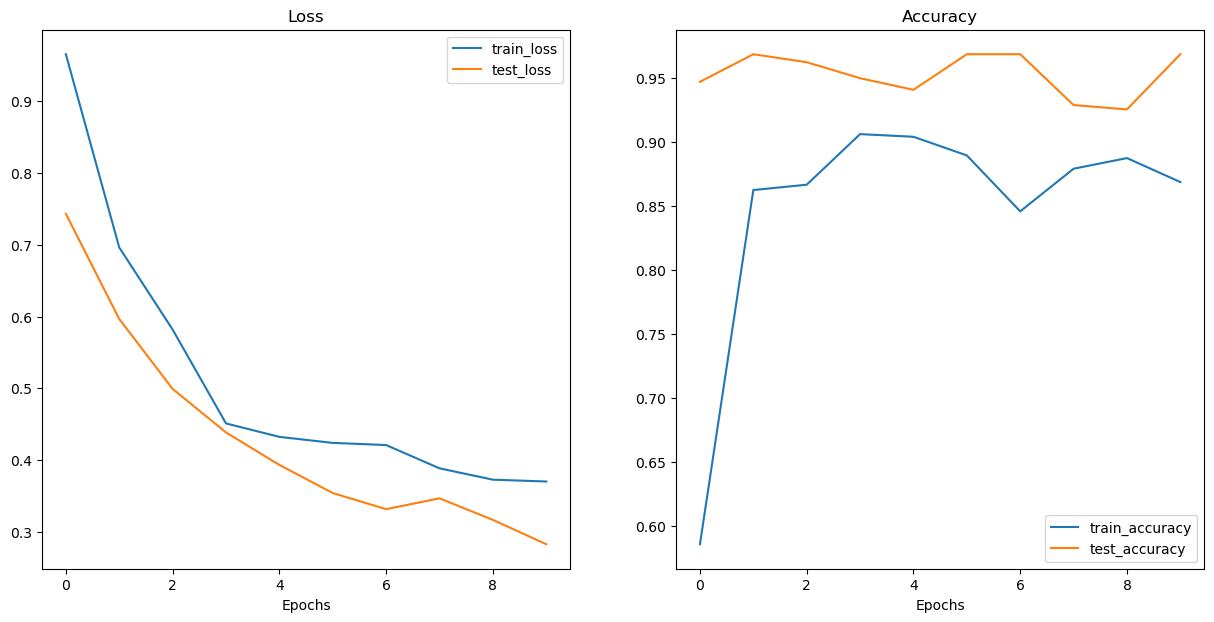

In [14]:
plot_loss_curves(effnetb2_results)

The model is performing quite well and perhaps would benefit from a little longer training and potentially some data augmentation (to help prevent potential overfitting occuring from longer training).

#### 3.5 Saving EffNetB2 feature extractor

In [15]:
from going_modular import utils

utils.save_model(model=effnetb2, target_dir="models",
                model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

Model is being saved at models\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


#### 3.6 Checking the size of EffNetB2 feature extractor model

This needs to be done as one of the deployment criteria is speed.

This is because the size of the model can influence its inference speed. Although not always the case.

As, if a model has more params, it generally perform more operations and each requires some computing power.

**Because the model needs to work on edge devices (with limited computing power), generally, the smaller the size the better.** (as long as it still performs well in terms of accuracy).

In [16]:
from pathlib import Path
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


#### 3.7 Collecting EffNetB2 feature extractor stats

Collecting a few statistics got from EffNetB2 model's training in a dictionary to compare them to the upcoming ViT feature extractor.

In [17]:
# Count number of params in EffNetB2 using torch.numel(), short for "number of elements"
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [18]:
# Create a dictionary with EffNetB2 statistics for comparison later
effnetb2_stats = {"test_loss" : effnetb2_results["test_loss"][-1],
                  "test_acc" : effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : effnetb2_total_params,
                  "model_size (MB)" : pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28262916803359983,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

**Hence, the first criteria is fulfilled i.e., the performance at 95%+ accuracy as can be seen in the stats dict.**

### 4. Creating a ViT feature extractor

In [19]:
# Inspect the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [20]:
# Functionalize the creation of the ViT-Base feature extractor model
def create_vit_model(num_classes: int=3, seed: int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.
    Returns a model and its transforms.
    """
    # Steps 1, 2, 3 similar to effnetb2 model are here
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Step 4
    for param in model.parameters():
        param.requires_grad = False

    # Step 5
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes)
    )

    return model, transforms

In [21]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3, seed=42)

In [22]:
# Get a summary of the ViT feature extractor model
summary(model = vit, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

The noticeable thing is that the ViT model has far more parameters than the EffNetB2 model. This will come into play while comparing them across speed and performance.

#### 4.1 Create DataLoaders for ViT

ViT model is ready. Time to create dataloaders for it.

In [23]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=vit_transforms, batch_size=32)

#### 4.2 Training ViT feature extractor

Both model and dataloaders are ready. Time to train the model on that data.

In [24]:
torch.cuda.empty_cache()

In [25]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Set the seeds and train the ViT model
set_seeds()
vit_results = engine.train(model=vit, train_dataloader=train_dataloader_vit, test_dataloader=test_dataloader_vit,
                          epochs=10, optimizer=optimizer, loss_fn=loss_fn, device=device)

 10%|████████▎                                                                          | 1/10 [00:54<08:06, 54.05s/it]


Epoch: 1 | train_loss: 0.5984 | train_acc: 0.8292 | test_loss: 0.2064 | test_acc: 0.9750


 20%|████████████████▌                                                                  | 2/10 [01:32<05:57, 44.64s/it]


Epoch: 2 | train_loss: 0.2348 | train_acc: 0.9250 | test_loss: 0.1279 | test_acc: 0.9938


 30%|████████████████████████▉                                                          | 3/10 [02:09<04:50, 41.45s/it]


Epoch: 3 | train_loss: 0.1633 | train_acc: 0.9604 | test_loss: 0.0996 | test_acc: 0.9875


 40%|█████████████████████████████████▏                                                 | 4/10 [02:47<03:59, 39.91s/it]


Epoch: 4 | train_loss: 0.1164 | train_acc: 0.9667 | test_loss: 0.0861 | test_acc: 0.9875


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:29<03:23, 40.74s/it]


Epoch: 5 | train_loss: 0.1055 | train_acc: 0.9688 | test_loss: 0.0763 | test_acc: 0.9938


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:11<02:44, 41.25s/it]


Epoch: 6 | train_loss: 0.1163 | train_acc: 0.9458 | test_loss: 0.0697 | test_acc: 0.9875


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:53<02:04, 41.39s/it]


Epoch: 7 | train_loss: 0.0828 | train_acc: 0.9792 | test_loss: 0.0749 | test_acc: 0.9812


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:32<01:21, 40.55s/it]


Epoch: 8 | train_loss: 0.0863 | train_acc: 0.9854 | test_loss: 0.0644 | test_acc: 0.9875


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [06:10<00:39, 39.78s/it]


Epoch: 9 | train_loss: 0.0876 | train_acc: 0.9854 | test_loss: 0.0604 | test_acc: 0.9875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:48<00:00, 40.81s/it]


Epoch: 10 | train_loss: 0.0607 | train_acc: 0.9854 | test_loss: 0.0576 | test_acc: 0.9875


#### 4.3 Inspecting ViT loss curves

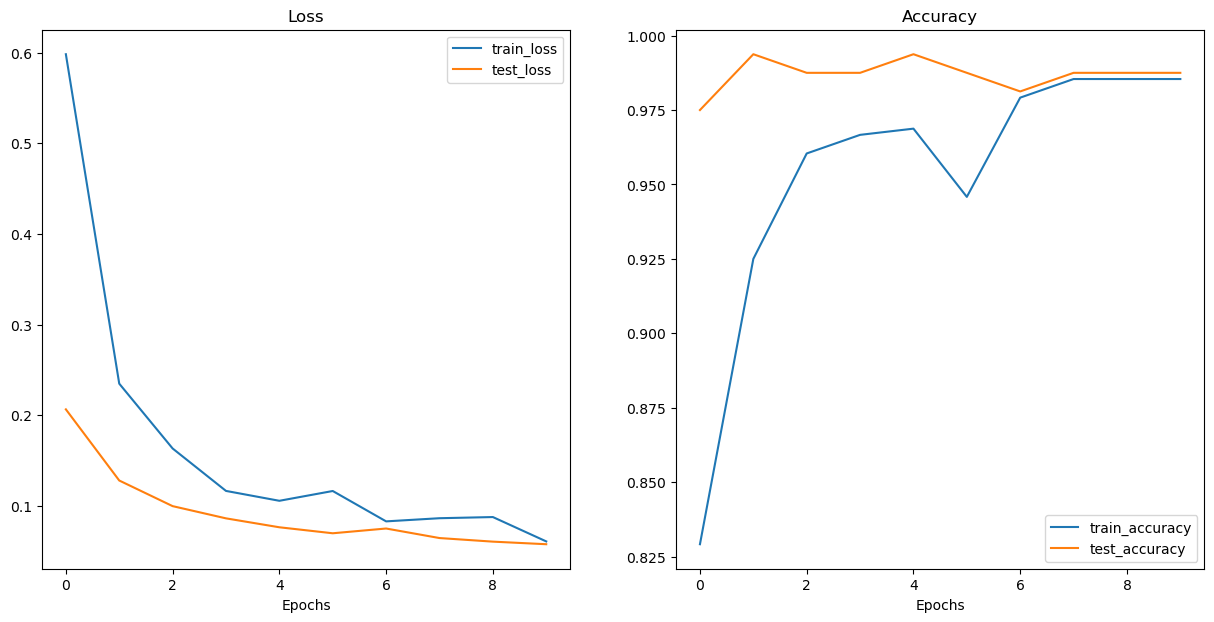

In [26]:
plot_loss_curves(vit_results)

These are some nice looking loss curves although would benefit from similar things as for EffNetB2 model.

#### 4.4 Saving ViT feature extractor model

In [27]:
utils.save_model(model=vit, target_dir="models",
                model_name="09_pretrained_vit_feature_extrctor_pizza_steak_sushi_20_percent.pth")

Model is being saved at models\09_pretrained_vit_feature_extrctor_pizza_steak_sushi_20_percent.pth


#### 4.5 Checking the size of ViT feature extractor

In [28]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extrctor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


This will be helpful in the comparision of the best models later on.

#### 4.6 Collecting ViT feature extractor stats

In [29]:
# Putting together all of the ViT feature extractor model statistics

# Count number of params in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

**A larger number of params (or wts/patterns) generally means a model has a higher capacity to learn. Also, If given more oppurtunities to learn i.e., more data. However, this larger capacity to learn often comes with an increased model filesize and a longer time to perform inference.**

In [30]:
# Create ViT statistics dictionary for comparision
vit_stats = {"test_loss" : vit_results["test_loss"][-1],
             "test_acc" : vit_results["test_acc"][-1],
             "number_of_parameters" : vit_total_params,
             "model_size (MB)" : pretrained_vit_model_size}

vit_stats

{'test_loss': 0.05759347495622933,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

ViT too achieves an accuracy of 95%+.

### 5. Making predictions with the trained models and timing them

Although both of the models are performing well, for deployment to a mobile device, the predictions are liked to happen at real-time. This is why the second criteria is a **fast model**.

To time each of the models inference performed, a function called **pred_and_store()** will be created to iterate over each of the test dataset images one by one and perform a prediction.

The prediciton made and time of that prediciton will be stored for each image in a list of dictionaries, where each dict in the list is a prediciton element.

This is done one by one because the end user using the deployed model will be using a simgle imsge at a time for prediciton. Not a batch of images to predict on.

In [31]:
# Get all of the test images paths in the target_dir to make predictions on
print(f"target_dir having all of the test images paths is: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

target_dir having all of the test images paths is: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

#### 5.1 Creating a function to make predictions across the test dataset

In [32]:
%%writefile going_modular/predict_and_store.py

import pathlib
import torch
import torchvision
from typing import List, Dict
from timeit import default_timer as timer
from PIL import Image
from tqdm.auto import tqdm

# 1. Create a function with its required parameters to return a list of dicts with sample, truth label, pred, pred proband pred time
def pred_and_store(test_paths: List[pathlib.Path], model: torch.nn.Module, transforms: torchvision.transforms,
                   class_names: List[str], device: str= "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    # 2. Create an empty list to store prediction dictionaries
    pred_results_list = []
    # 3. Loop through the target input (test images) paths
    for path in tqdm(test_paths):
        # 4. Create an empty dict for each iteration to store pred values per sample
        pred_dict = {}
        # 5. Get sample path and ground truth class name
        pred_dict["image_path"] = path
        gnd_truth_class = path.parent.stem
        pred_dict["gnd_truth_class"] = gnd_truth_class
        # 6. Start the pred timer using timeit library
        start_time = timer()
        # 7. Open image in the path using PIL
        image = Image.open(path)
        # 8. Tranform image to be compatible with the PyTorch model, add a batch dimension and send the image to the target device
        transformed_image = transforms(image).unsqueeze(0).to(device)
        # 9. Prepare model for inference by turning on eval() mode and sending it to the target device
        model.to(device)
        model.eval()
        # 10. Turn on inference mode, pass the target transformed img to model, calculate pred prob and target label
        with torch.inference_mode():
            pred_logits = model(transformed_image)
            pred_probs = torch.softmax(pred_logits, dim = 1)
            pred_label = torch.argmax(pred_probs, dim = 1)
            pred_class = class_names[pred_label.cpu()]
            # 11. Add pred prob and pred class to the pred dict created in step 4; Make sure they are on CPU
            pred_dict["pred_probs"] = round(pred_probs.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            # 12. End the pred timer started in step 6 and add time to pred dict in step 4
            end_time = timer()
            elapsed_time = round(end_time - start_time, 4)
            pred_dict["pred_time"] = elapsed_time
        # 13. Check if gnd truth in step 5 and pred_class match, then add the result to pred dict in step 4
        pred_dict["gndtrth_predclass_match"] = (gnd_truth_class == pred_class)
        # 14. Append updated pred dict to empty list of predictions created in step 2
        pred_results_list.append(pred_dict)
    # 15. Return the list of pred dicts
    return pred_results_list

Overwriting going_modular/predict_and_store.py


#### 5.2 Making and timing predictions with EffNetB2

In [33]:
from going_modular.predict_and_store import pred_and_store

# Hard coded device to be "cpu" because "cuda" is not always accessed when deployed and preds on cpu will be a good incidator of speed of inference
effnetb2_test_pred_dicts = pred_and_store(test_paths=test_data_paths, model=effnetb2, transforms=effnetb2_transforms,
                                         class_names=class_names, device="cpu") # hard coded

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:13<00:00, 11.25it/s]


In [34]:
# Inspect the first few to see how they look
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'gnd_truth_class': 'pizza',
  'pred_probs': 0.9958,
  'pred_class': 'pizza',
  'pred_time': 1.8302,
  'gndtrth_predclass_match': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'gnd_truth_class': 'pizza',
  'pred_probs': 0.4288,
  'pred_class': 'pizza',
  'pred_time': 0.0801,
  'gndtrth_predclass_match': True}]

In [35]:
import pandas as pd
# To further inspect the stats in list of dicts data structure, turn this list of dicts into a pandas DataFrame
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,gnd_truth_class,pred_probs,pred_class,pred_time,gndtrth_predclass_match
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9958,pizza,1.8302,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4288,pizza,0.0801,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9910,pizza,0.0674,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6391,pizza,0.0796,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7471,pizza,0.0749,True


**This conversion of list of dicts to a pandas DataFrame will help in performing analysis easily on test preds.**

In [36]:
# Check number of correct preds
effnetb2_test_pred_df.gndtrth_predclass_match.value_counts()

gndtrth_predclass_match
True     145
False      5
Name: count, dtype: int64

In [37]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.pred_time.mean(), 4)
str(effnetb2_average_time_per_pred.item()) + " seconds"

'0.088 seconds'

**Prediction times will be different across different hardware types. However, the better and faster the hardware, generally, the faster the prediction.**

In [38]:
# Add EffNetB2 average prediction time to stats dict
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred.item()
effnetb2_stats

{'test_loss': 0.28262916803359983,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.088}

#### 5.3 Making and timing predictions with ViT

In [39]:
vit_test_pred_dicts = pred_and_store(test_paths=test_data_paths, model=vit, transforms=vit_transforms, class_names=class_names, device="cpu")

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.91it/s]


In [40]:
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'gnd_truth_class': 'pizza',
  'pred_probs': 0.9985,
  'pred_class': 'pizza',
  'pred_time': 0.5898,
  'gndtrth_predclass_match': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'gnd_truth_class': 'pizza',
  'pred_probs': 0.9955,
  'pred_class': 'pizza',
  'pred_time': 0.3247,
  'gndtrth_predclass_match': True}]

In [41]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,gnd_truth_class,pred_probs,pred_class,pred_time,gndtrth_predclass_match
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9985,pizza,0.5898,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9955,pizza,0.3247,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9966,pizza,0.2824,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9843,pizza,0.3045,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9776,pizza,0.2724,True


In [42]:
# Number of correct preds?
vit_test_pred_df.gndtrth_predclass_match.value_counts()

gndtrth_predclass_match
True     148
False      2
Name: count, dtype: int64

In [43]:
# Average prediction time per sample of ViT model
vit_average_time_per_pred = round(vit_test_pred_df.pred_time.mean(), 4)
str(vit_average_time_per_pred.item()) + " seconds"

'0.255 seconds'

In [44]:
# Add the avg pred time to the vit stats dict for further comparison
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred.item()
vit_stats

{'test_loss': 0.05759347495622933,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.255}

### 6. Comparing model results, prediction times and size

In [45]:
# Turn stats dictionaries into DataFrames
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentage
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.282629,96.88,7705221,29,0.088,EffNetB2
1,0.057593,98.75,85800963,327,0.255,ViT


In [46]:
# Compare ViT to EffNetB2 across different characteristics by finding diff ratios b/w them by division
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # Division of VIT stats by EffNetB2 stats
            columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.203778,1.019302,11.135432,11.275862,2.897727


**ViT model outperforms the EffNetB2 model across the performance metrics (test loss and test accuracy) but at the expense of**:

    11x+ the number of params
    11x+ the model size
    2.5x+ the prediction time per image

However, these tradeoffs are not worth it for deploying on edge devices with constrained computing power.   

So, would likely be starting out with the EffNetB2 model for faster preds at a slightly reduced performance but dramatically smaller size.

#### 6.1 Visualizing the speed vs. performance tradeoff

**Performance or inference time is also often referred to as latency.**

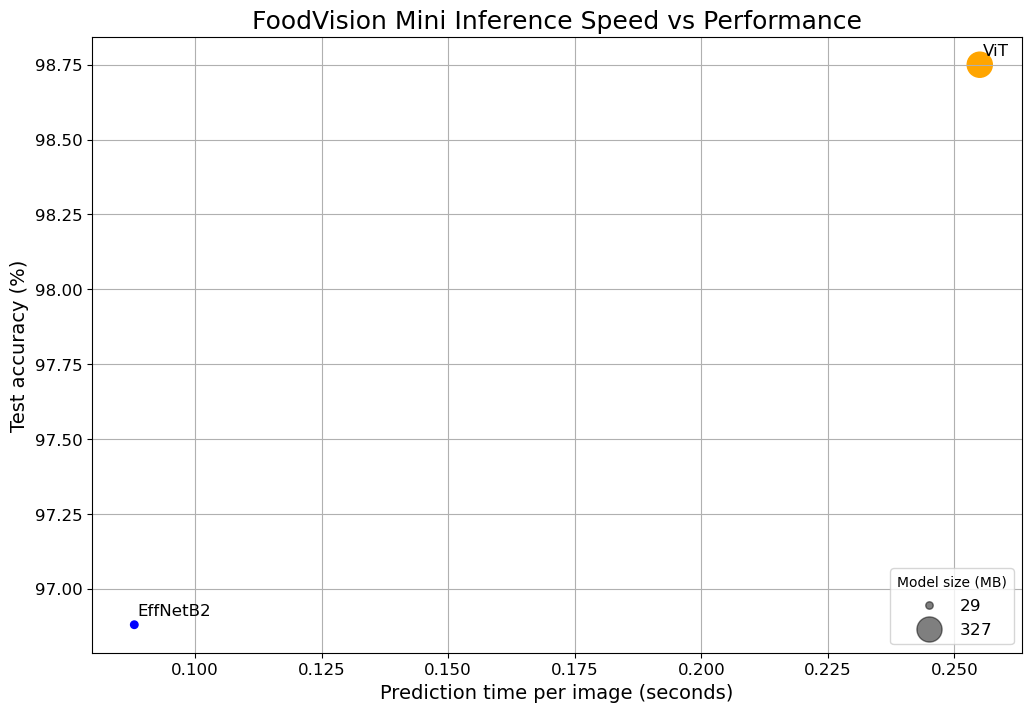

In [47]:
# 1. Create a plot from model comparison DataFrame, df
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, x = "time_per_pred_cpu", y = "test_acc", c = ["blue", "orange"],
                      s = "model_size (MB)") # Size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate samples on the plot with the model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03), size=12)

# 4. Create legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, labels, loc="lower right", title="Model size (MB)", fontsize=12)

# Save the figure
import os
os.makedirs("images", exist_ok = True)
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

So, the plot visualizes the tradeoff in a good way. However, going to stick with deploying the EffNetB2 model since it is faster and has a much smaller footprnt.

### 7. Bringing FoodVision Mini to life by creating a Gradio demo

Gradio is the fastest way to demo an ML model with a friendly web interface so that anyone can use it, anywhere.

Demonstration of the models is important because metrcis on test set look nice but it is never really known how the model performs until used in the wild.

In [48]:
# Install or import Gradio accordingly
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(gr.__version__)

5.44.1


#### 7.1 Gradio overview

Gradio emulates the paradigm of (inputs, black box functioning, outputs), as is of ML models, by creating an interface from inputs to outputs.

    gradio.Interface(fn, inputs, outputs)

Here, fn is a Python function to map the inputs to the outputs.

![Gradio Visual Representation](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-gradio-workflow.png)

*Gradio provides a very helpful **Interface** class to easily create an inputs -> model/function -> outputs workflow where the inputs and outputs could be almost anything you want. For example, you might input Tweets (text) to see if they're about machine learning or not or input a text prompt to generate images.*

Gradio has a vast number of possible inputs and outputs options known as **Components**.

#### 7.2 Creating a function to map the inputs and outputs

This function will be the **fn** parameter for the Gradio Interface.

In [49]:
# Ensure EffNetB2 is on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [50]:
from typing import Tuple, Dict

# Creating a function predict(), similar to pred_and_store() function, to replicate the above workflow
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Timer start
    start_time = timer()
    
    # Transform the image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Get model into eval() mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn pred logits to pred probs
        pred_logits = effnetb2(img)
        pred_probs = torch.softmax(pred_logits, dim = 1)
    
    # Create pred label and pred prob dict for each pred class (this is the reqd format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the pred time
    pred_time = round(timer() - start_time, 5)
    
    # return pred dict and pred time
    return pred_labels_and_probs, pred_time

In [51]:
import random
from PIL import Image
from timeit import default_timer as timer

# Get list of all image paths from test directory
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select an image path from that list
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the image
image = Image.open(random_image_path)
print(f"Predicting on the image at path: {random_image_path}")

# Predict on the random image
pred_dict, pred_time = predict(img=image)
print(f"Pred label and prob dict: \n{pred_dict}")
print(f"Pred time: {pred_time} seconds")

Predicting on the image at path: data\pizza_steak_sushi_20_percent\test\sushi\1994748.jpg
Pred label and prob dict: 
{'pizza': 0.06300856918096542, 'steak': 0.3712386190891266, 'sushi': 0.5657528042793274}
Pred time: 0.10609 seconds


#### 7.3 Creating a list of example images

Gradio's Interface class takes a list of examples of as an optional parameter: **Gradio.Interface(examples=List[Any])**

The format for this examples parameter is a list of lists.

In [52]:
# Creating a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\steak\\1882831.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\219196.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\124279.jpg']]

Displayed will be these examples when users use the demo app/site without any image uploads by the user.

#### 7.4 Building a Gradio interface

Put everything together into a living FoodVision Mini demo.

A Gradio Interface can be created using gradio.Interface() with the following parameters:

    fn - Python function mapping inputs to outputs, predict() function here.
    inputs - i/ps to the interface, gradio.Image() or "image"
    outputs - o/ps of the interface once the i/ps have gone through fn, gradio.Label() for pred labels and gradio.Number() for model's pred time.
    examples - example_list
    title - A string title of the demo
    description - A string description of the demo
    article - A reference note at the bottom of the demo

After the demo instance creation of gr.Interface(), it can be launched using gradio.Interface.launch() or demo.launch().

In [53]:
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(debug=False, # print errors locally ?
            share=True) # Generate a publically shareable link ?

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Hence, a demo is ready. Although shareable link could not be generated.

### 8. Turning the FoodVision Mini Gradio Demo into a deployable app

To make the FoodVision Mini demo more permanent, can package it into an app and upload it to Hf Spaces.

#### 8.1 What is Hugging Face Spaces ?

A resource allowing to host and share ML apps.

HF can be thought of as the GitHub of ML.

#### 8.2 Deployed Gradio app structure

Here, **app.py** contans the Gradio app; lanuch code for it. This is the default filename used for HF Spaces, if deployed there. **model.py** contains model definition and any transforms associated with it.

Will be working towards recreating the file structure above now. This way is used because it is one of the simplest layouts to begin with. However, **Experimentation is the key.**

#### 8.3 Creating a demos folder to store the FoodVision Mini app files

In [54]:
import shutil

# Model demo app directory path creation
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove any already existing files there and create new dir
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)

# If file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

# Check the things in the created path
!dir demos\foodvision_mini\

 Volume in drive C is Windows-SSD
 Volume Serial Number is 284D-8FBA

 Directory of C:\Users\ritis\Desktop\PyTorch-Learning\demos\foodvision_mini

16-09-2025  13:36    <DIR>          .
16-09-2025  13:36    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  22,464,233,472 bytes free


#### 8.4 Creating an example images folder to use with the FoodVision Mini demo

In [56]:
# 1. Create examples dir
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents = True, exist_ok = True)

# 2. Collect random test images' paths
foodvision_mini_examples = [Path('data\\pizza_steak_sushi_20_percent\\test\\sushi\\3494950.jpg'),
                            Path('data\\pizza_steak_sushi_20_percent\\test\\pizza\\148765.jpg'),
                            Path('data\\pizza_steak_sushi_20_percent\\test\\steak\\831681.jpg')]

# 3. Copy these 3 random images to the examples dir
for example in foodvision_mini_examples:
    dest = foodvision_mini_examples_path / example.name
    print(f"Copying {example} to {dest}")
    shutil.copy2(src=example, dst=dest)

Copying data\pizza_steak_sushi_20_percent\test\sushi\3494950.jpg to demos\foodvision_mini\examples\3494950.jpg
Copying data\pizza_steak_sushi_20_percent\test\pizza\148765.jpg to demos\foodvision_mini\examples\148765.jpg
Copying data\pizza_steak_sushi_20_percent\test\steak\831681.jpg to demos\foodvision_mini\examples\831681.jpg


In [57]:
# Verifying the examples are present, and format filepaths into a list of lists for compatibility of example param of gradio.Interface()
example_list = [["examples/" + ex] for ex in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/148765.jpg'], ['examples/3494950.jpg'], ['examples/831681.jpg']]

#### 8.5 Moving the trained EffNetB2 model to the FoodVision Mini demo directory

Rather than doubling the saved model files, move the model to the demo foodvision directory.

In [58]:
# Source path set for target file
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Destination path set for the target file to move to
effnetb2_foodvision_mini_model_dest = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
    print(f"Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_dest}")
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, dst=effnetb2_foodvision_mini_model_dest)
    print("Model move complete.")

# Check if the model has already been moved and if it exists
except:
    print(f"No model found at {effnetb2_foodvision_mini_model_path}, perhaps already been moved?")
    print(f"Model exists at {effnetb2_foodvision_mini_model_dest}: {effnetb2_foodvision_mini_model_dest.exists()}")

Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
Model move complete.


#### 8.6 Turning the EffNetB2 model into a Python script (model.py)

In [59]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

# Functionalize the EffNetB2 feature extractor model creation
def create_effnetb2_model(num_classes: int=3, seed: int=42):
    """Creates an EfficientNetB2 feature extractor model and its transforms.
    Returns the model and transforms.
    """
    # 1, 2, 3 Steps here
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Step 4
    for param in model.parameters():
        param.requires_grad = False

    # Step 5
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


#### 8.7 Turning the FoodVision Mini Gradio app into a Python script (app.py)

app.py will put everything together to create Gradio demo and will have four main parts:

    1. Imports and class names setup
    2. Model and transforms preparation
    3. Predict function
    4. Gradio app

In [60]:
%%writefile demos/foodvision_mini/app.py
# Step 1
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

## Setup class names
class_names = ["pizza", "steak", "sushi"]

# Step 2
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))
effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
                                   map_location=torch.device("cpu"), weights_only = True))

# Step 3
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Timer start
    start_time = timer()
    
    # Transform the image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Get model into eval() mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn pred logits to pred probs
        pred_logits = effnetb2(img)
        pred_probs = torch.softmax(pred_logits, dim = 1)
    
    # Create pred label and pred prob dict for each pred class (this is the reqd format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the pred time
    pred_time = round(timer() - start_time, 5)
    
    # return pred dict and pred time
    return pred_labels_and_probs, pred_time   

# Step 4
## Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

## Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

## Create the Gradio demo
demo = gr.Interface(fn=predict, inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

## Launch the demo
demo.launch()

Writing demos/foodvision_mini/app.py


#### 8.8 Creating a requirements file for FoodVision Mini (requirements.txt)

In [61]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.5.0
torchvision==0.20.0
gradio==5.44.1

Writing demos/foodvision_mini/requirements.txt


**Now, have got all the files needed to deploy the FoodVision Mini demo.**

### 9. Deploying the FoodVision Mini app to HF Spaces

All the things for the demo app are ready to be deployed now.

However, a couple of options are there for uploading to a HF Space:

    1. Upload via HF Web interface
    2. Upload via command line/terminal or can use huggingface_hub library to interact with HF.

#### 9.1 Downloading the FoodVision Mini app files

In [62]:
!dir demos\foodvision_mini

 Volume in drive C is Windows-SSD
 Volume Serial Number is 284D-8FBA

 Directory of C:\Users\ritis\Desktop\PyTorch-Learning\demos\foodvision_mini

16-09-2025  13:38    <DIR>          .
16-09-2025  13:36    <DIR>          ..
16-09-2025  13:25        31,314,554 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
16-09-2025  13:38             2,462 app.py
16-09-2025  13:38    <DIR>          examples
16-09-2025  13:38               795 model.py
16-09-2025  13:38                51 requirements.txt
               4 File(s)     31,317,862 bytes
               3 Dir(s)  22,461,501,440 bytes free


Do not need to do this section of code since not running this notebook in Google Colab. Already in local.

#### 9.2 Running the FoodVision Mini demo locally

This section has the usual testing of the app locally before final upload to the HF Space. Nothing new. Just unzip the folder if using Google Colab beofre testing. That's all!

#### 9.3 Uploading to HF

**Successfully uploaded.**

In [63]:
# Embedding the Gradio demo into the notebook as an iframe

# This lib helps make Python interactive
from IPython.display import IFrame

# Embed the demo
IFrame(src="https://ritish369-foodvision-mini-learning.hf.space", width=900, height=750)

### 10. Creating FoodVision Big

![title](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-model-deployment-foodvision-mini-to-foodvision-big.png)

#### 10.1 Creating a model and transforms for FoodVision Big

In [64]:
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [65]:
# Get a summary of the created model
summary(model=effnetb2_food101, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [66]:
# Performing Data Augmentation over training data thus, creating the necessary training data transforms
# Done to increase the data diversity to prevent overfitting; as the data being dealt with here is relatively more.
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [67]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing/inference transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing/inference transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


#### 10.2 Getting data for FoodVision Big

In [68]:
from torchvision import datasets

# Setup data dir
data_dir = Path("data")

# Get training data; 75%
train_data = datasets.Food101(root=data_dir, split="train", transform=food101_train_transforms, download=True)

# Get testing data; 25%
test_data = datasets.Food101(root=data_dir, split="test", transform=effnetb2_transforms, download=True)

In [69]:
# Get Food101 class names
food101_class_names = train_data.classes
food101_class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

#### 10.3 Creating a subset of the Food101 dataset for faster experimenting

The goal is to see if the original Food101 paper's best results can be beaten with only 20% of the data.

As the model size slowly increased overtime, the dataset size being used for experiments also increased.

This is done in order to do faster training. Although the whole training and evaluation of the model can be done on the complete Food101 dataset. Also, some compute constraints are also present.

In [70]:
def split_dataset(dataset: torchvision.datasets, split_size: float=0.2, seed: int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Returns:
        tuple: (random_split_1, randm_split_2); size of random_split_1 is split_size*len(dataset) and the other size is (1-split_size)*len(dataset).
    """
    # Create split lengths based on split_size and dataset length
    length_1 = int(split_size * len(dataset)) # target 20% split length
    length_2 = len(dataset) - length_1 # remaining length

    # Print the lengths
    print(f"Og dataset length: {len(dataset)} splitted into {length_1}, {int(split_size*100)}% split and {length_2}, {int((1-split_size)*100)}% split")

    # Create splits with random seed value
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, lengths=[length_1, length_2], generator=torch.manual_seed(seed)) # seed for reproducible splits

    return random_split_1, random_split_2

In [71]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(train_data, split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(test_data, split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

Og dataset length: 75750 splitted into 15150, 20% split and 60600, 80% split
Og dataset length: 25250 splitted into 5050, 20% split and 20200, 80% split


(15150, 5050)

**Dataset splitted successfully for 20% split.**

#### 10.4 Turning the Food101 (20% splits) datasets into DataLoaders

In [72]:
BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # experimental value depending on the hardware being used

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle = True,
                                                                 num_workers=NUM_WORKERS)

# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                BATCH_SIZE,
                                                                shuffle = False,
                                                                num_workers=NUM_WORKERS)

#### 10.5 Training FoodVision Big model

Model and the DataLoaders are ready respectively. Time to do training.

In [73]:
# Setup optimizer and loss function
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1) # label smoothing is a regularization technique because of many output classes so that not a single dominant class under consideration only by the model

# Train the model with a goal of beating 56.4% accuracy on the test set of the Food101 paper's results
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101, train_dataloader=train_dataloader_food101_20_percent, test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer, loss_fn=loss_fn, epochs=5, device=device)

 20%|████████████████▌                                                                  | 1/5 [02:52<11:30, 172.72s/it]


Epoch: 1 | train_loss: 3.6323 | train_acc: 0.2864 | test_loss: 2.7651 | test_acc: 0.4895


 40%|█████████████████████████████████▏                                                 | 2/5 [05:40<08:29, 169.91s/it]


Epoch: 2 | train_loss: 2.8629 | train_acc: 0.4389 | test_loss: 2.4646 | test_acc: 0.5403


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [08:17<05:27, 163.87s/it]


Epoch: 3 | train_loss: 2.6534 | train_acc: 0.4871 | test_loss: 2.3536 | test_acc: 0.5584


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [10:50<02:39, 159.54s/it]


Epoch: 4 | train_loss: 2.5454 | train_acc: 0.5126 | test_loss: 2.3044 | test_acc: 0.5745


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:48<00:00, 165.67s/it]


Epoch: 5 | train_loss: 2.4947 | train_acc: 0.5269 | test_loss: 2.2827 | test_acc: 0.5768


Beat the results but was only on 20% split data. Not the complete test set. Conclusions can be made based on evaluation on 100% test set.

#### 10.6 Inspecting loss curves of FoodVision Big model

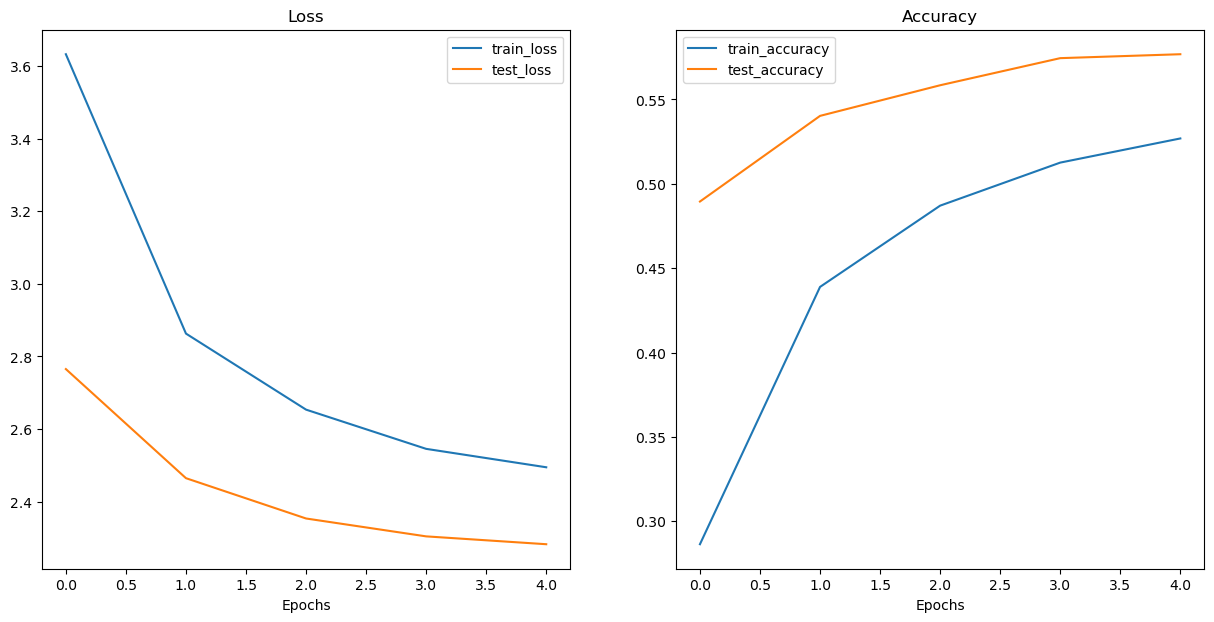

In [74]:
plot_loss_curves(effnetb2_food101_results)

There is no overfitting seen because of the use of regularization techniques such as data augmentation and label smoothing. However, the train loss is still higher than the test loss which indicates the model has a bit more capacity to learn and could improve with further training.

#### 10.7 Saving and loading FoodVision Big

In [75]:
# Create model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save the model
utils.save_model(model=effnetb2_food101, target_dir="models", model_name=effnetb2_food101_model_path)

Model is being saved at models\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [76]:
# Ensuring that the saved model can be loaded back in by indeed loading it

# Food101 model instance creation
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth", weights_only=True))

<All keys matched successfully>

#### 10.8 Checking FoodVision Big model size

In [77]:
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


This model's size is similar to FoodVision Mini's size which is 29 MB.

Only the difference is because of the increase in the number of params in the last layer of FoodVision Big model sine both models have the same base layers.

### 11. Turning the FoodVision Big model into a deployable app

In [78]:
# FoodVision Big demo dir path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Create its demo dir now
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Create FoodVision Big examples dir
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

#### 11.1 Downloading an ex img and moving it to the examples dir

The author's provided pizza image will be used as the example image here.

In [79]:
# Remove the Food101 tar file to save space
!del data\food-101.tar.gz

# Copy the example image from data/04-pizza-author.jpeg to demos/foodvision_big/examples/
!copy data\04-pizza-author.jpeg demos\foodvision_big\examples\04-pizza-author.jpeg

# Move the trained model file ass well to demos dir
!move models\09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos\foodvision_big

Could Not Find C:\Users\ritis\Desktop\PyTorch-Learning\data\food-101.tar.gz


        1 file(s) copied.
        1 file(s) moved.


#### 11.2 Saving Food101 class names to file (class_names.txt)

In [80]:
# class names text file path creation
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"Saving class names to {foodvision_big_class_names_path}.")
    f.write("\n".join(food101_class_names)) # a new line b/w each class

Saving class names to demos\foodvision_big\class_names.txt.


In [81]:
# Ensuring that the content of the file can be read

# Open file in read mode and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()]

# View the list
food101_class_names_loaded[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

#### 11.3 Turning the FoodVision Big model into a Python script (model.py)

In [82]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes: int=3, seed: int=42):
    """Creates an EffNetB2 feature extractor model and transforms.
    Return:
        model, transforms
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all the base layers in the model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

Writing demos/foodvision_big/model.py


#### 11.4 Turning the FoodVision Big Gradio app into a Python script (app.py)

In [89]:
%%writefile demos/foodvision_big/app.py
# 1. Imports and class names setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Dict, Tuple

## Setup class names
with open("class_names.txt", "r") as f:
    class_names = [food.strip() for food in f.readlines()]

# 2. Model and transforms preparation
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

## Load the saved model weights
effnetb2.load_state_dict(torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
                                    weights_only=True, map_location=torch.device("cpu")))

# 3. Predict function
def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim = 1)

    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    end_time = timer()
    pred_time = round(end_time - start_time, 5)

    return pred_labels_and_probs, pred_time

# 4. Gradio app
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(fn=predict, inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes = 5, label="Predictions"), gr.Number(label="Prediction time (s)")],
                   examples = example_list, title=title, description=description, article=article)

demo.launch()

Overwriting demos/foodvision_big/app.py


#### 11.5 Creating the requirements file for FoodVision Big (requirements.txt)

In [90]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.5.0
torchvision==0.20.0
gradio==5.44.1

Overwriting demos/foodvision_big/requirements.txt


#### 11.6 Downloading the FoodVision app files

Not needed to be done since working on Jupyter Notebook locally. Not on Google Colab.

#### 11.7 Deploying the FoodVision Big app to HF Spaces

**Successfully ddeployed.**

In [92]:
# Embedding the FoodVision Big Gradio demo here in the notebook
from IPython.display import IFrame
IFrame(src="https://ritish369-foodvision-big-learning.hf.space", width = 900, height = 750)

Therefore,

    Deployment is as important as training.
    
    Ask the 3 questions for ML model deployment (ideal use case -- performance vs speed, on-device/cloud and online/offline preds).
    
    Deployment options are a plenty.
    
    Never stop experimenting.
    
    ML model deployment is part of the engineering practice of MLOps (involves all the engg parts around training a model).